# Remark
This project intended to see how sensitive the model is if we vary the amount of neuron on the hidden layer (we will call it $n_h$), and how our test accuracy related to the $n_h$ on various dataset.

By: Musa Izzanardi Wijanarko

In [119]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sds
from sklearn.model_selection import train_test_split

# Create Dataset
We create 4 types of dataset from scikit-learn. That is moons, blobs, quantiles, and flower. Each dataset has different trend and spread.

In [120]:
# acquire dataset

class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)     
    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) 
        Y = np.zeros(self.N, dtype='uint8')
        a = 4 

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

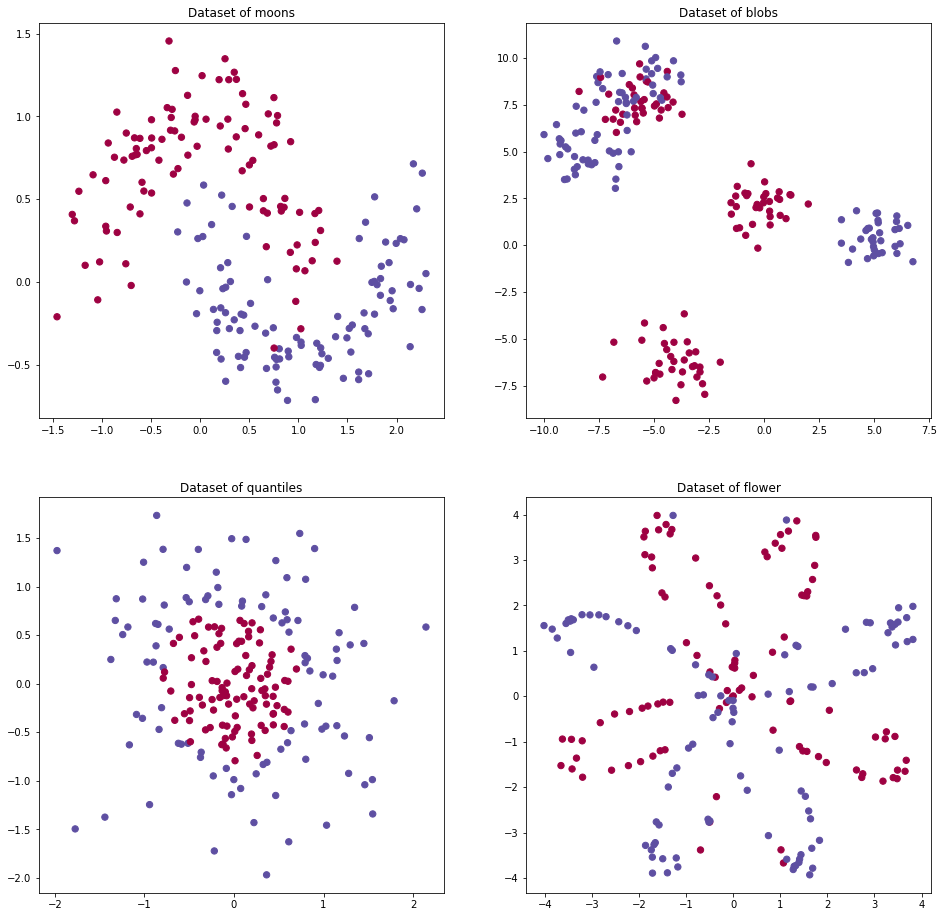

In [121]:
# Visualization for each dataset

dataset_lst = [
    'moons', #0
    'blobs', #1
    'quantiles', #2
    'flower', #3
]
plt.figure(figsize=(16, 16))
for i, shape in enumerate(dataset_lst):
    plt.subplot(2, 2, i+1)
    plt.title("Dataset of "+shape)
    X, Y = loader.load_dataset(shape)  
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

# Activation Funciton
We will use sigmoid function and hyperbolic tangent as this dataset only have 2 label.

In [122]:
# define our activation function
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

#the tanh will use np.tanh

# Decision Boundary Function

This functions enable us to see the visualized data (after our model has been trained) better using `plt.contourf().`

In [123]:
# define a plot decision boundary function

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

# The SNN

We will use 2 layer neural network with simple gradient descent to update our parameters.

In [124]:
#Shallow Neural Network

def initialize_parameters(n_x, n_h, n_y):    
    # Initialize W and b. With W are random and b = 0 at the start.
    w1 = np.random.randn(n_x,n_h)
    b1 = np.zeros([n_h,1])
    w2 = np.random.randn(n_h,n_y)
    b2 = np.zeros([n_y,1])
    
    return w1, w2, b1, b2

#forward propagation
def forward_propagation(X, w1, w2, b1, b2):
    Z1 = np.dot(w1.T,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(w2.T,A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

#backward propagation
def backward_propagation(A1, A2, w2, X, Y):
    m = X.shape[1]

    dZ2 = ((-2*(Y-A2))/m)*A2*(1-A2) #dsigmoid
    dw2 = np.dot(A1,dZ2.T)
    
    db2 = np.sum(dZ2)
    dZ1 = np.dot(w2,dZ2)*(1-A1**2)  #dtanh
    dw1 = np.dot(X,dZ1.T)
    
    db1 = np.sum(dZ1)
    
    return dw1, dw2, db1, db2

# Gradient Descent Optimization for Updating Parameters
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2

#Other function
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example

    cost = np.dot((Y-A2),(Y-A2).T)/m
    return float(np.squeeze(cost))

def predict(parameters, X):
    w1, w2, b1, b2 = parameters
    A1, A2 = forward_propagation(X,w1,w2,b1,b2)
    predictions = A2
    return predictions

def get_accuracy(parameters, X, Y,t):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print(t,"accuracy: {:.2f} %".format(accuracy))

def float_accuracy(Y,predictions):
  acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
  return acc

In [125]:
#Final function
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    w1, w2, b1 , b2 = parameters
    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, w1, w2, b1, b2)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1,A2, w2, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [126]:
#number of hidden neuron
hidden_neuron = 4

#set custom loader
loader = PlanarDataset(200)

# Moons Dataset

In [127]:
X, Y = loader.load_dataset("moons")
X_train,X_test,Y_train,Y_test = train_test_split(X.T,Y.T,random_state=2)
X_train,X_test,Y_train,Y_test = X_train.T,X_test.T,Y_train.T,Y_test.T

#training the data
parameters = nn_model(X_train, Y_train, hidden_neuron, 100000, 0.05, True)

Cost after iteration 0: 0.230511
Cost after iteration 10000: 0.039080
Cost after iteration 20000: 0.026658
Cost after iteration 30000: 0.023424
Cost after iteration 40000: 0.021715
Cost after iteration 50000: 0.020536
Cost after iteration 60000: 0.019611
Cost after iteration 70000: 0.018832
Cost after iteration 80000: 0.018148
Cost after iteration 90000: 0.017533


train accuracy: 95.66 %


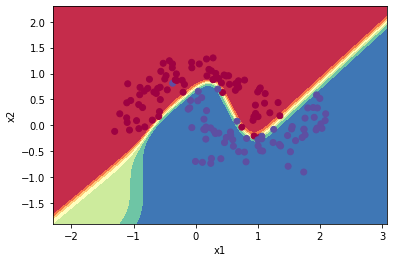

In [128]:
get_accuracy(parameters, X_train, Y_train,'train')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_train, Y_train)

test accuracy: 96.50 %


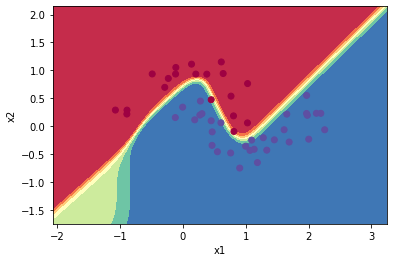

In [129]:
get_accuracy(parameters, X_test, Y_test,'test')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)

In [130]:
hidden_layer_sizes = np.arange(1, 72, 5)
accuracy_test = []
accuracy_train = []
for n_h in hidden_layer_sizes:
    parameters = nn_model(X_train, Y_train, n_h, num_iterations = 10000)
    predictions_train = predict(parameters, X_train)
    predictions_test = predict(parameters, X_test)
    acc_train = float_accuracy(Y_train,predictions_train)
    acc_test = float_accuracy(Y_test,predictions_test)
    print ("Accuracy train and test for {} hidden neuron: {:.2f} %".format(n_h, acc_train), "and {:.2f} %".format(acc_test))
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)

Accuracy train and test for 1 hidden neuron: 78.69 % and 77.85 %
Accuracy train and test for 6 hidden neuron: 97.25 % and 97.78 %
Accuracy train and test for 11 hidden neuron: 97.23 % and 97.77 %
Accuracy train and test for 16 hidden neuron: 97.42 % and 97.94 %
Accuracy train and test for 21 hidden neuron: 96.76 % and 97.31 %
Accuracy train and test for 26 hidden neuron: 97.26 % and 97.83 %
Accuracy train and test for 31 hidden neuron: 97.31 % and 97.80 %
Accuracy train and test for 36 hidden neuron: 97.30 % and 97.78 %
Accuracy train and test for 41 hidden neuron: 96.98 % and 97.56 %
Accuracy train and test for 46 hidden neuron: 97.08 % and 97.56 %
Accuracy train and test for 51 hidden neuron: 97.22 % and 97.78 %
Accuracy train and test for 56 hidden neuron: 97.31 % and 97.91 %
Accuracy train and test for 61 hidden neuron: 96.87 % and 97.47 %
Accuracy train and test for 66 hidden neuron: 97.01 % and 97.49 %
Accuracy train and test for 71 hidden neuron: 96.73 % and 97.34 %


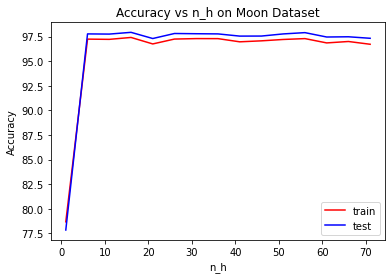

In [131]:
plt.title("Accuracy vs n_h on Moon Dataset")
plt.ylabel("Accuracy")
plt.xlabel("n_h")

plt.plot(hidden_layer_sizes, accuracy_train,'r',label='train')
plt.plot(hidden_layer_sizes, accuracy_test,'b',label='test')
plt.legend()
plt.show()

# Blobs Dataset

In [147]:
X, Y = loader.load_dataset("blobs")
X_train,X_test,Y_train,Y_test = train_test_split(X.T,Y.T,random_state=2)
X_train,X_test,Y_train,Y_test = X_train.T,X_test.T,Y_train.T,Y_test.T

#training the data
parameters = nn_model(X_train, Y_train, hidden_neuron, 100000, 0.05, True)

Cost after iteration 0: 0.248041
Cost after iteration 10000: 0.074025
Cost after iteration 20000: 0.063948
Cost after iteration 30000: 0.061459
Cost after iteration 40000: 0.060153
Cost after iteration 50000: 0.059270
Cost after iteration 60000: 0.058625
Cost after iteration 70000: 0.058130
Cost after iteration 80000: 0.057739
Cost after iteration 90000: 0.057421


train accuracy: 86.95 %


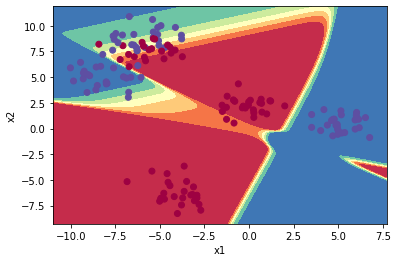

In [148]:
get_accuracy(parameters, X_train, Y_train,'train')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_train, Y_train)

test accuracy: 80.71 %


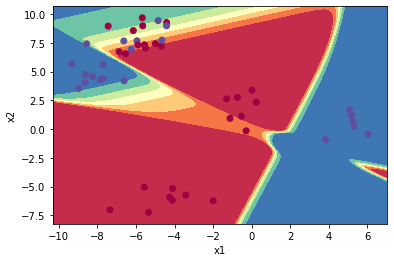

In [149]:
get_accuracy(parameters, X_test, Y_test,'test')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)

In [150]:
hidden_layer_sizes = np.arange(1, 72, 5)
accuracy_test = []
accuracy_train = []
for n_h in hidden_layer_sizes:
    parameters = nn_model(X_train, Y_train, n_h, num_iterations = 10000)
    predictions_train = predict(parameters, X_train)
    predictions_test = predict(parameters, X_test)
    acc_train = float_accuracy(Y_train,predictions_train)
    acc_test = float_accuracy(Y_test,predictions_test)
    print ("Accuracy train and test for {} hidden neuron: {:.2f} %".format(n_h, acc_train), "and {:.2f} %".format(acc_test))
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)

Accuracy train and test for 1 hidden neuron: 62.15 % and 57.88 %
Accuracy train and test for 6 hidden neuron: 79.94 % and 72.05 %
Accuracy train and test for 11 hidden neuron: 84.80 % and 79.24 %
Accuracy train and test for 16 hidden neuron: 85.27 % and 79.48 %
Accuracy train and test for 21 hidden neuron: 91.52 % and 79.05 %
Accuracy train and test for 26 hidden neuron: 93.72 % and 81.09 %
Accuracy train and test for 31 hidden neuron: 91.72 % and 82.09 %
Accuracy train and test for 36 hidden neuron: 91.93 % and 80.67 %
Accuracy train and test for 41 hidden neuron: 91.13 % and 82.72 %
Accuracy train and test for 46 hidden neuron: 92.51 % and 84.23 %
Accuracy train and test for 51 hidden neuron: 92.04 % and 80.45 %
Accuracy train and test for 56 hidden neuron: 92.24 % and 79.41 %
Accuracy train and test for 61 hidden neuron: 93.81 % and 80.82 %
Accuracy train and test for 66 hidden neuron: 93.80 % and 83.60 %
Accuracy train and test for 71 hidden neuron: 92.82 % and 79.55 %


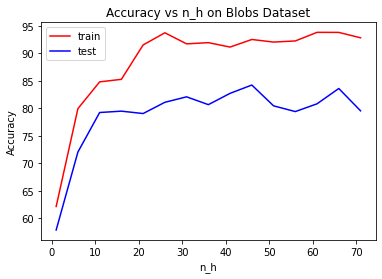

In [151]:
plt.title("Accuracy vs n_h on Blobs Dataset")
plt.ylabel("Accuracy")
plt.xlabel("n_h")

plt.plot(hidden_layer_sizes, accuracy_train,'r',label='train')
plt.plot(hidden_layer_sizes, accuracy_test,'b',label='test')
plt.legend()
plt.show()

# Quantiles Dataset

In [137]:
X, Y = loader.load_dataset("quantiles")
X_train,X_test,Y_train,Y_test = train_test_split(X.T,Y.T,random_state=2)
X_train,X_test,Y_train,Y_test = X_train.T,X_test.T,Y_train.T,Y_test.T

#training the data
parameters = nn_model(X_train, Y_train, hidden_neuron, 100000, 0.05, True)

Cost after iteration 0: 0.249746
Cost after iteration 10000: 0.050493
Cost after iteration 20000: 0.036756
Cost after iteration 30000: 0.030908
Cost after iteration 40000: 0.027568
Cost after iteration 50000: 0.024663
Cost after iteration 60000: 0.020500
Cost after iteration 70000: 0.017093
Cost after iteration 80000: 0.014831
Cost after iteration 90000: 0.013144


train accuracy: 94.32 %


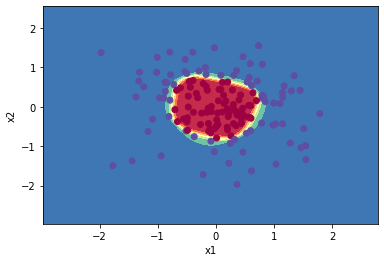

In [138]:
get_accuracy(parameters, X_train, Y_train,'train')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_train, Y_train)

test accuracy: 91.40 %


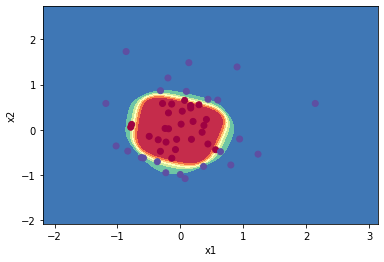

In [139]:
get_accuracy(parameters, X_test, Y_test,'test')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)

In [140]:
hidden_layer_sizes = np.arange(1, 72, 5)
accuracy_test = []
accuracy_train = []
for n_h in hidden_layer_sizes:
    parameters = nn_model(X_train, Y_train, n_h, num_iterations = 10000)
    predictions_train = predict(parameters, X_train)
    predictions_test = predict(parameters, X_test)
    acc_train = float_accuracy(Y_train,predictions_train)
    acc_test = float_accuracy(Y_test,predictions_test)
    print ("Accuracy train and test for {} hidden neuron: {:.2f} %".format(n_h, acc_train), "and {:.2f} %".format(acc_test))
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)

Accuracy train and test for 1 hidden neuron: 59.38 % and 59.37 %
Accuracy train and test for 6 hidden neuron: 97.45 % and 94.15 %
Accuracy train and test for 11 hidden neuron: 97.82 % and 94.46 %
Accuracy train and test for 16 hidden neuron: 98.16 % and 94.58 %
Accuracy train and test for 21 hidden neuron: 98.25 % and 94.58 %
Accuracy train and test for 26 hidden neuron: 98.35 % and 95.00 %
Accuracy train and test for 31 hidden neuron: 98.52 % and 95.01 %
Accuracy train and test for 36 hidden neuron: 98.48 % and 94.85 %
Accuracy train and test for 41 hidden neuron: 98.50 % and 94.93 %
Accuracy train and test for 46 hidden neuron: 98.54 % and 95.00 %
Accuracy train and test for 51 hidden neuron: 98.62 % and 94.72 %
Accuracy train and test for 56 hidden neuron: 98.64 % and 94.88 %
Accuracy train and test for 61 hidden neuron: 98.66 % and 95.03 %
Accuracy train and test for 66 hidden neuron: 98.67 % and 94.98 %
Accuracy train and test for 71 hidden neuron: 98.62 % and 94.76 %


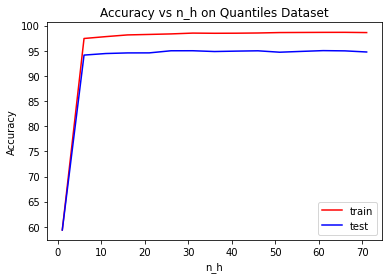

In [141]:
plt.title("Accuracy vs n_h on Quantiles Dataset")
plt.ylabel("Accuracy")
plt.xlabel("n_h")

plt.plot(hidden_layer_sizes, accuracy_train,'r',label='train')
plt.plot(hidden_layer_sizes, accuracy_test,'b',label='test')
plt.legend()
plt.show()

# Flower Dataset

In [142]:
X, Y = loader.load_dataset("flower")
X_train,X_test,Y_train,Y_test = train_test_split(X.T,Y.T,random_state=2)
X_train,X_test,Y_train,Y_test = X_train.T,X_test.T,Y_train.T,Y_test.T

#training the data
parameters = nn_model(X_train, Y_train, hidden_neuron, 100000, 0.05, True)

Cost after iteration 0: 0.310418
Cost after iteration 10000: 0.082725
Cost after iteration 20000: 0.079106
Cost after iteration 30000: 0.077383
Cost after iteration 40000: 0.074893
Cost after iteration 50000: 0.072725
Cost after iteration 60000: 0.071090
Cost after iteration 70000: 0.069750
Cost after iteration 80000: 0.068626
Cost after iteration 90000: 0.067674


train accuracy: 85.61 %


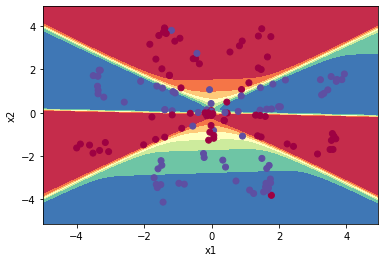

In [143]:
get_accuracy(parameters, X_train, Y_train,'train')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_train, Y_train)

test accuracy: 79.84 %


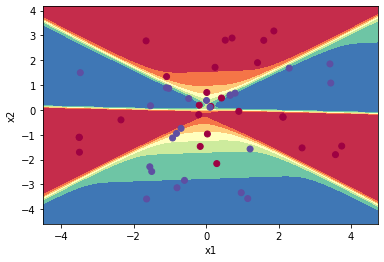

In [144]:
get_accuracy(parameters, X_test, Y_test,'test')
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)

In [145]:
hidden_layer_sizes = np.arange(1, 72, 5)
accuracy_test = []
accuracy_train = []
for n_h in hidden_layer_sizes:
    parameters = nn_model(X_train, Y_train, n_h, num_iterations = 10000)
    predictions_train = predict(parameters, X_train)
    predictions_test = predict(parameters, X_test)
    acc_train = float_accuracy(Y_train,predictions_train)
    acc_test = float_accuracy(Y_test,predictions_test)
    print ("Accuracy train and test for {} hidden neuron: {:.2f} %".format(n_h, acc_train), "and {:.2f} %".format(acc_test))
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)

Accuracy train and test for 1 hidden neuron: 55.04 % and 52.00 %
Accuracy train and test for 6 hidden neuron: 90.64 % and 86.74 %
Accuracy train and test for 11 hidden neuron: 92.08 % and 87.55 %
Accuracy train and test for 16 hidden neuron: 92.13 % and 87.84 %
Accuracy train and test for 21 hidden neuron: 92.29 % and 88.01 %
Accuracy train and test for 26 hidden neuron: 92.03 % and 87.22 %
Accuracy train and test for 31 hidden neuron: 92.27 % and 87.67 %
Accuracy train and test for 36 hidden neuron: 92.57 % and 89.01 %
Accuracy train and test for 41 hidden neuron: 92.51 % and 88.06 %
Accuracy train and test for 46 hidden neuron: 92.80 % and 87.58 %
Accuracy train and test for 51 hidden neuron: 92.79 % and 87.39 %
Accuracy train and test for 56 hidden neuron: 92.63 % and 87.76 %
Accuracy train and test for 61 hidden neuron: 93.18 % and 88.90 %
Accuracy train and test for 66 hidden neuron: 92.53 % and 88.01 %
Accuracy train and test for 71 hidden neuron: 93.72 % and 87.88 %


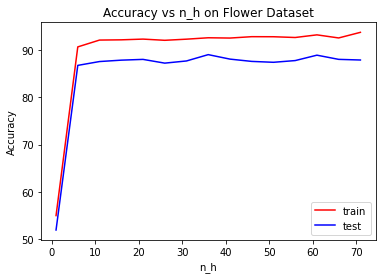

In [146]:
plt.title("Accuracy vs n_h on Flower Dataset")
plt.ylabel("Accuracy")
plt.xlabel("n_h")

plt.plot(hidden_layer_sizes, accuracy_train,'r',label='train')
plt.plot(hidden_layer_sizes, accuracy_test,'b',label='test')
plt.legend()
plt.show()

# Conclusion

For dataset that pretty well organized such as moons, quantiles, and flower, we achieve pretty good accuracy when $n_h = 6$, and the accuracy didn't increase much when $n_h$ gets larger. Different results obtained in blobs dataset, which is less organized than the other three. We can see that blobs dataset need $n_h = 46$ to reach maximum test accuracy, and more than that results in overfitting. We can conclude that small number of neuron in hidden layer is enough to obtain a pretty decent SNN model for simple data with trivial pattern.